## Introduction

You are working as an ML engineer in Visiemo, a famous sound-based sentiment analysis company. It’s Monday morning and you are chilling at the coffee machine with fellow Visiumees. Suddenly, the AI project manager schedules you a project kick-off meeting. A multinational client is interested in our services: the client has different call centers around the world and would like to analyze the satisfaction of its customers based on the recordings of the calls.

The client has heard about AI and Visiemo, more precisely about our expertise in sentiment analysis.
However,the client is reluctant in whether the solution will work. As such, it has been agreed to first do a proof-of-concept on the call centers from Germany.

At Visiemo, we have decided to use an already existing dataset and design a small proof-of-concept to showcase the solution to the client.

## Instructions

In the frame of this use-case, you will be confronted to **Speech Emotion Recognition** with the **Emo-DB** dataset. The goal is to design a proof-of-concept model which classifies samples of emotional speech in one of the given emotions.

By the end of the use-case, you should have a working model with good enough performance, fairly evaluated. 

*We do not aim to have the best performing model.* On the contrary, you should aim for an end-to-end working solution that enables inference on new speech samples.

* As a **report**, you should fill in the present notebook.
* You should dockerize your project. The **Docker container** should handle everything (download the data, run the code, etc.). When running the container **it should expose the Jupyter notebook on one port and expose a Flask API on another one**.
* The **Flask API** should contain two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* The code that you will develop should be **entirely reproducible** and **documented in a README.md file**.

## Final presentation

* The final presentation will be held on-site or remotely depending on your availability. 
* An AI Project Manager and two ML engineers will be present. 
* You will start by giving a 10-15 min technical presentation about your approach and your findings, using the slides provided as deliverables. Finally, a discussion with questions of about 20 min will follow.
* It should be clear enough to understand your approach and your decisions without going too much in the code. 
* You can also include code snippets, demos, etc.

## Important points to keep in mind

* Please be aware that this use-case might take a substantial amount of time, especially if you are not familiar with all the tools.
* You will have one full week to tackle the problem, starting today. We broadly estimate to *15-20 hours* the usual development time needed.
* Don’t spend too much time finding the perfect technical solution or making tiny metric improvements. 
* If you don't manage to finish all the tasks, you can still send us your use-case: we will discuss the difficulties you encountered during the final presentation.
* **Do not upload your code to Github, or at least not in a public repo.**
* Feel free to use any available library you would need, but **do not re-use someone else's code without mentioning it.**

## Deliverables 

Please provide the following elements in a **.zip** file as deliverables:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work.
* A **Dockerfile** defining a container for the project expositing the present notebook and the Flask API.
* A **README.md** which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* **Any** necessary .py, .sh or other files needed to run your code.

You will be judged on your technical approach, evaluation, visualizations, coding and presentation skills.

## About the data

The dataset can be found [here](http://emodb.bilderbar.info/index-1280.html).

It contains samples of emotional speech in German, labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information").

# Libraries Loading

In [ ]:
from os import listdir
from os.path import isfile, join
from scipy.io import wavfile
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from sklearn.model_selection import train_test_split

from models import *
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from time import strftime, time
import sys

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Data Preparation & Cleaning

In [ ]:
filename = 'data/wav'
wav_files = listdir(filename)
print('There are totally {} wav files'.format(len(wav_files)))

There are totally 535 wav files


Now, we will load random wav files, and visualize them.

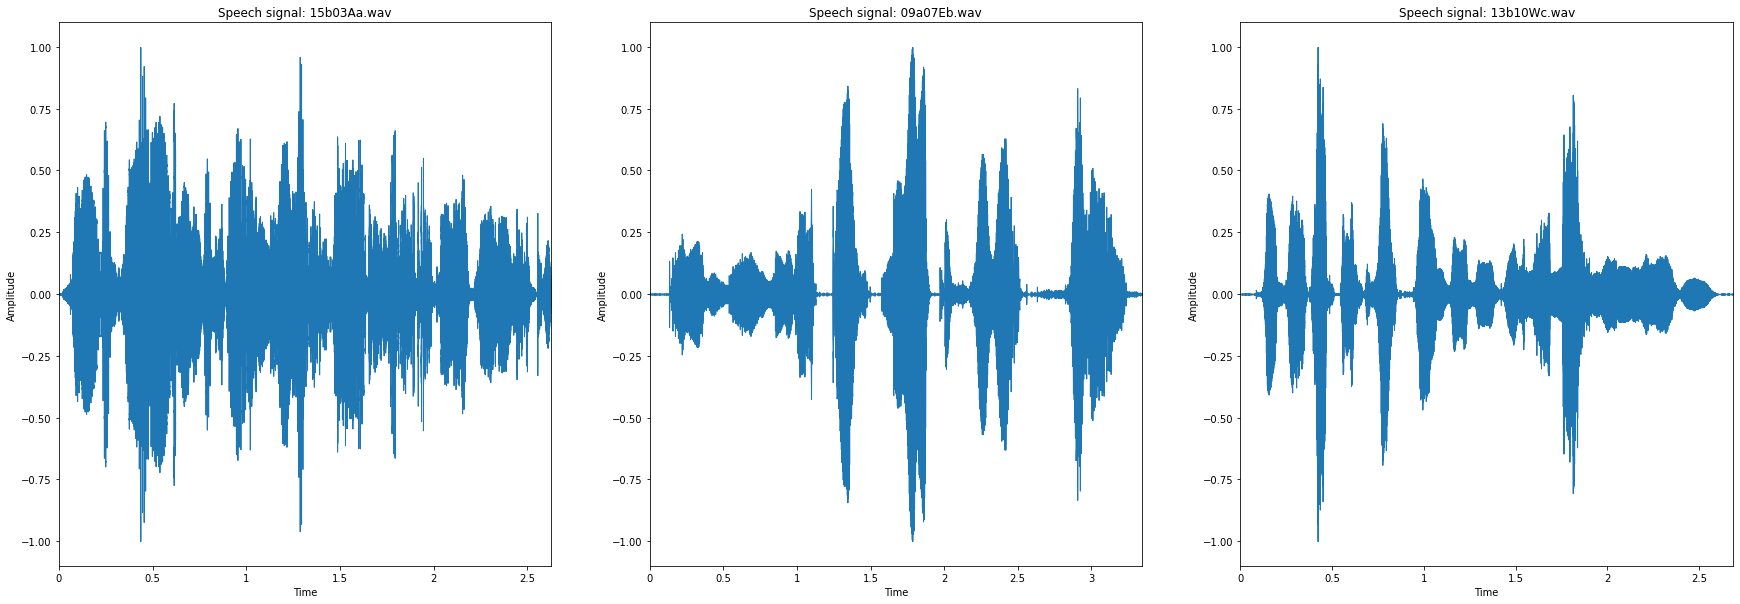

In [ ]:
indices = np.random.randint(len(wav_files), size=3)

plt.figure(figsize=(30,10))
for i,index in enumerate(indices):
    signal, _sr = librosa.load(join(filename, wav_files[index]), sr=None)
    ax = plt.subplot(1, 3, i+1)
    librosa.display.waveplot(signal, sr=_sr, ax=ax)
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.set_title('Speech signal: {}'.format(wav_files[index]))
plt.show()

Then, I visualize the distribution of classes of the dataset. We can see the labels are not uniformly distributed.

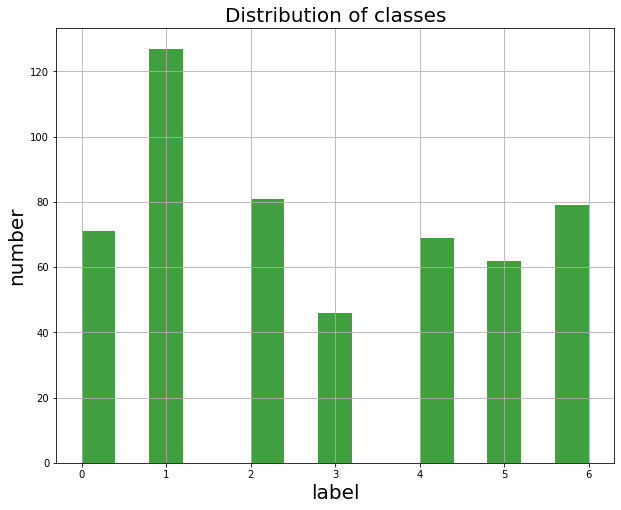

In [ ]:
y = FileNameLabel(wav_files)

plt.figure(figsize= (10,8))
_ = plt.hist(y, 15, facecolor='g', alpha=0.75)
plt.grid(True)
plt.title('Distribution of classes', fontsize=20)
plt.xlabel('label', fontsize=20)
plt.ylabel('number', fontsize=20)
plt.show()

From above plots, we can see different speech signals have different length. Thus, we need to do zero padding for the signals to make them constant length. Also, We can see the labels are not uniformly distributed, so I will split dataset into train set and test set in a stratified fashion. Also, there are only 535 wav files, so we need to do data augmentation for the train set.

**Load wav files into speech signals**

In [ ]:
dataset = []
lengths = []

for file in wav_files:
    signal, _sr = librosa.load(join(filename, file), sr=None)
    length = signal.shape[0]

    dataset.append(signal)
    lengths.append(length)

y = FileNameLabel(wav_files)
max_length = max(lengths)

**Split dataset into train set and test set in a stratified fashion.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=42, stratify=y)

**Data augmentation**

In [ ]:
aug_X_train, aug_y_train = augmentation(X_train, y_train, n_aug=10)

Start augmentation
End augmentation


In [ ]:
print('Before augmentation, there are totally {} train samples'.format(len(X_train)))
X_train.extend(aug_X_train)
y_train.extend(aug_y_train) 
print('After augmentation, there are totally {} train samples'.format(len(X_train)))

Before augmentation, there are totally 428 train samples
After augmentation, there are totally 4708 train samples


**Zero padding**

Zero padding is just used to align the speech signals. In the following methods,I do the mean along the row axis. Thus, zero padding is not necessary for the feature extraction.

In [ ]:
pad_X_train = zero_padding(X_train, max_length)
pad_X_test = zero_padding(X_test, max_length)

In [ ]:
pad_X_train.shape, pad_X_test.shape

((4708, 143652), (107, 143652))

We can see the samples are with constant lengths.

# Feature Engineering & Modeling

For feature extraction, I consider following 5 features:



*   MFCC (mfcc)
*   Chroma (chroma)
*   MEL Spectrogram Frequency (mel)
*   Contrast (contrast)
*   Tonnetz (tonnetz)

Below, I display the five features of one random speech signal.

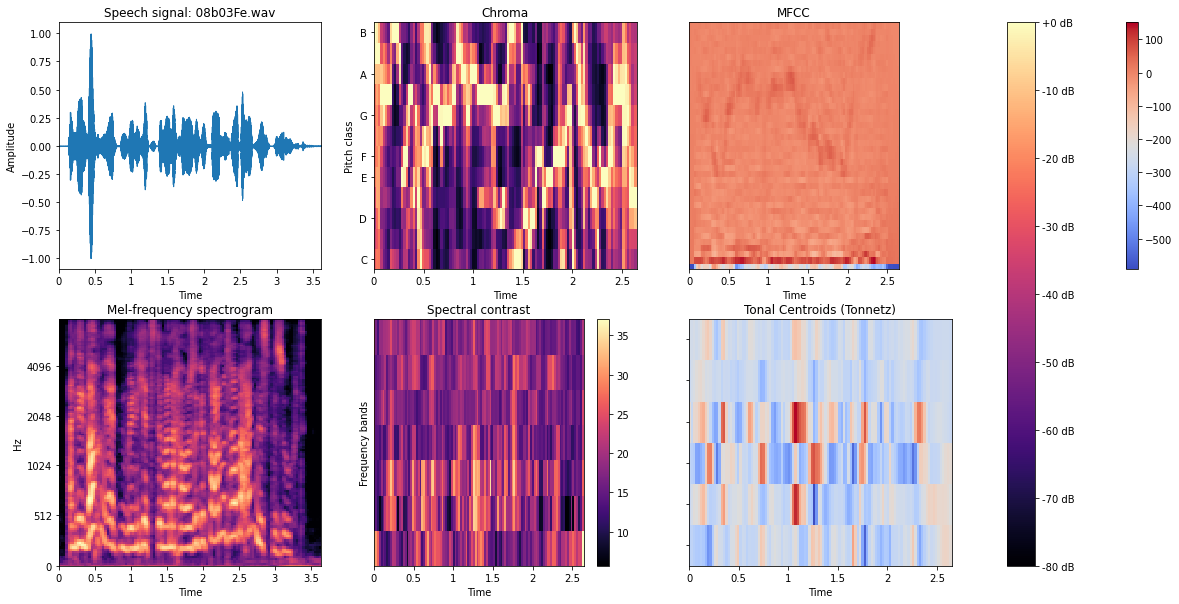

In [ ]:
from IPython.core.pylabtools import figsize
index = np.random.randint(len(wav_files), size=1)
signal, _sr = librosa.load(join(filename, wav_files[index[0]]), sr=None)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

#ax = plt.subplot(2, 3, 1)
librosa.display.waveplot(signal, sr=_sr, ax=ax[0][0])
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_title('Speech signal: {}'.format(wav_files[index[0]]))

stft = np.abs(librosa.stft(signal))
chroma = librosa.feature.chroma_stft(S=stft, sr=_sr)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[0][1])
ax[0][1].set_title('Chroma')

mfcc = librosa.feature.mfcc(y=signal, sr=_sr, n_mfcc=40)
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax[0][2])
fig.colorbar(img, ax=[ax[0][2]])
ax[0][2].set_title('MFCC')

mel = librosa.feature.melspectrogram(signal, sr=_sr)
S_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',\
                y_axis='mel', sr=_sr,\
                fmax=8000, ax=ax[1][0])
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax[1][0].set(title='Mel-frequency spectrogram')

contrast = librosa.feature.spectral_contrast(S=stft, sr=_sr)
img = librosa.display.specshow(contrast, x_axis='time', ax=ax[1][1])
fig.colorbar(img, ax=[ax[1][1]])
ax[1][1].set(ylabel='Frequency bands', title='Spectral contrast')

tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(signal), sr=10000)
img = librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time', ax=ax[1][2])
ax[1][2].set(title='Tonal Centroids (Tonnetz)')
ax[1][2].label_outer()

Now, we will extract meaningful features from speech signals

In [ ]:
X_train_features = extract_feature(X_train)
X_test_features = extract_feature(X_test)

**Save the features**

In [ ]:
np.save("train_features.npy", X_train_features)
np.save("train_y.npy", y_train)
np.save("test_features.npy", X_test_features)
np.save("test_y.npy", y_test)

In [ ]:
X_train_features = np.load("train_features.npy")
y_train = np.load("train_y.npy")
X_test_features = np.load("test_features.npy")
y_test = np.load("test_y.npy")

X_train_features = np.expand_dims(X_train_features, axis=1)
X_test_features = np.expand_dims(X_test_features, axis=1)

**Convert to Pytorch dataset**

In [ ]:
train_set = torch.utils.data.TensorDataset(torch.from_numpy(X_train_features), torch.from_numpy(y_train))
test_set = torch.utils.data.TensorDataset(torch.from_numpy(X_test_features), torch.from_numpy(y_test))

**Summary of the model**

In [ ]:
model = SpeechCNN()
model.cuda()
summary(model, [(1, 193)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 256, 193]           1,536
       BatchNorm1d-2             [-1, 256, 193]             512
              ReLU-3             [-1, 256, 193]               0
           Dropout-4             [-1, 256, 193]               0
             Block-5             [-1, 256, 193]               0
            Conv1d-6             [-1, 128, 193]         163,968
       BatchNorm1d-7             [-1, 128, 193]             256
              ReLU-8             [-1, 128, 193]               0
           Dropout-9             [-1, 128, 193]               0
            Block-10             [-1, 128, 193]               0
           Conv1d-11              [-1, 64, 193]          41,024
      BatchNorm1d-12              [-1, 64, 193]             128
             ReLU-13              [-1, 64, 193]               0
          Dropout-14              [-1, 

**Cross validation to find the best hyperparameters including learning rate, weight decay and gamma for the exponential learning rate scheduler.**

In [ ]:
cross_validation(train_set, lr_list=[1e-1, 1e-2, 1e-3], wd_list=[1e-3, 5e-3, 1e-4], gamma_list=[0.9, 0.85, 0.95])

流式输出内容被截断，只能显示最后 5000 行内容。
Time: 0.2672, Epoch: 37, Epoch iters: 50 / 59	Loss: 0.4612, Acc: 1.000000
 [15/15]Epoch:37.	Acc: 0.971.	 Best_Acc:0.986 (epoch: 40).
Time: 0.0082, Epoch: 38, Epoch iters: 0 / 59	Loss: 0.0087, Acc: 1.000000
Time: 0.0584, Epoch: 38, Epoch iters: 10 / 59	Loss: 0.0962, Acc: 1.000000
Time: 0.1148, Epoch: 38, Epoch iters: 20 / 59	Loss: 0.1737, Acc: 1.000000
Time: 0.1660, Epoch: 38, Epoch iters: 30 / 59	Loss: 0.2503, Acc: 1.000000
Time: 0.2138, Epoch: 38, Epoch iters: 40 / 59	Loss: 0.3427, Acc: 1.000000
Time: 0.2632, Epoch: 38, Epoch iters: 50 / 59	Loss: 0.4292, Acc: 1.000000
 [15/15]Epoch:38.	Acc: 0.971.	 Best_Acc:0.986 (epoch: 40).
Time: 0.0081, Epoch: 39, Epoch iters: 0 / 59	Loss: 0.0051, Acc: 1.000000
Time: 0.0553, Epoch: 39, Epoch iters: 10 / 59	Loss: 0.0869, Acc: 1.000000
Time: 0.1042, Epoch: 39, Epoch iters: 20 / 59	Loss: 0.1722, Acc: 1.000000
Time: 0.1567, Epoch: 39, Epoch iters: 30 / 59	Loss: 0.2500, Acc: 1.000000
Time: 0.2065, Epoch: 39, Epoch iters: 40 / 

{'gamma': 0.95, 'lr': 0.001, 'score': 0.9861995753715499, 'wd': 0.005}

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    print("No GPU :(")
    device = 'cpu'

# Batch size
BATCH_SIZE = 64

# dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# number of epochs
nb_epochs = 100

# learning rate
LR = 1e-3

# weight decay
WD = 5e-3

# loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# model
net = SpeechCNN().to(device)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=WD)

# scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
# create file to save the trained model
current_path = os.getcwd()
result_path = join(current_path, 'results')

if not os.path.exists(result_path):
    os.makedirs(result_path)


best_acc, best_epoch = 0, 0
train_stats, test_stats = [], []

for epoch in range(1, nb_epochs + 1):
    net, trainstate = train(train_loader, net, optimizer, loss_fn, epoch, device)

    # # testing mode to evaluate accuracy. 
    acc, teststate = test(test_loader, net, loss_fn, epoch, device=device)
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch
        outpath = join(result_path, 'net_best.pkl')
        torch.save(net, outpath)

    msg = 'Epoch:{}.\tAcc: {:.03f}.\t Best_Acc:{:.03f} (epoch: {}).'
    print(msg.format(epoch,  acc, best_acc, best_epoch))

    train_stats.append(trainstate)
    test_stats.append(teststate)     
    
    scheduler.step()

np.save(join(result_path, 'train_stats.npy'), train_stats) 
np.save(join(result_path, 'test_stats.npy'), test_stats)

Time: 0.7326, Epoch: 1, Epoch iters: 0 / 74	Loss: 1.9216, Acc: 0.296875
Time: 0.7842, Epoch: 1, Epoch iters: 10 / 74	Loss: 22.8194, Acc: 0.291193
Time: 0.8329, Epoch: 1, Epoch iters: 20 / 74	Loss: 35.1682, Acc: 0.380208
Time: 0.8820, Epoch: 1, Epoch iters: 30 / 74	Loss: 45.0274, Acc: 0.453125
Time: 0.9314, Epoch: 1, Epoch iters: 40 / 74	Loss: 55.3391, Acc: 0.483994
Time: 0.9798, Epoch: 1, Epoch iters: 50 / 74	Loss: 64.7646, Acc: 0.514706
Time: 1.0295, Epoch: 1, Epoch iters: 60 / 74	Loss: 72.9265, Acc: 0.543545
Time: 1.0770, Epoch: 1, Epoch iters: 70 / 74	Loss: 80.1161, Acc: 0.569982
 [2/2]Epoch:1.	Acc: 0.561.	 Best_Acc:0.561 (epoch: 1).
Time: 0.0075, Epoch: 2, Epoch iters: 0 / 74	Loss: 0.6367, Acc: 0.781250
Time: 0.0575, Epoch: 2, Epoch iters: 10 / 74	Loss: 7.6073, Acc: 0.731534
Time: 0.1054, Epoch: 2, Epoch iters: 20 / 74	Loss: 16.0500, Acc: 0.694940
Time: 0.1553, Epoch: 2, Epoch iters: 30 / 74	Loss: 22.9769, Acc: 0.711694
Time: 0.2038, Epoch: 2, Epoch iters: 40 / 74	Loss: 29.6832, Ac

# Results & Visualizations

In [ ]:
current_path = os.getcwd()
result_path = join(current_path, 'results')

train_stats = np.load(join(result_path, 'train_stats.npy'), allow_pickle=True)
test_stats =np.load(join(result_path, 'test_stats.npy'), allow_pickle=True)

The best test accuracy is 0.81


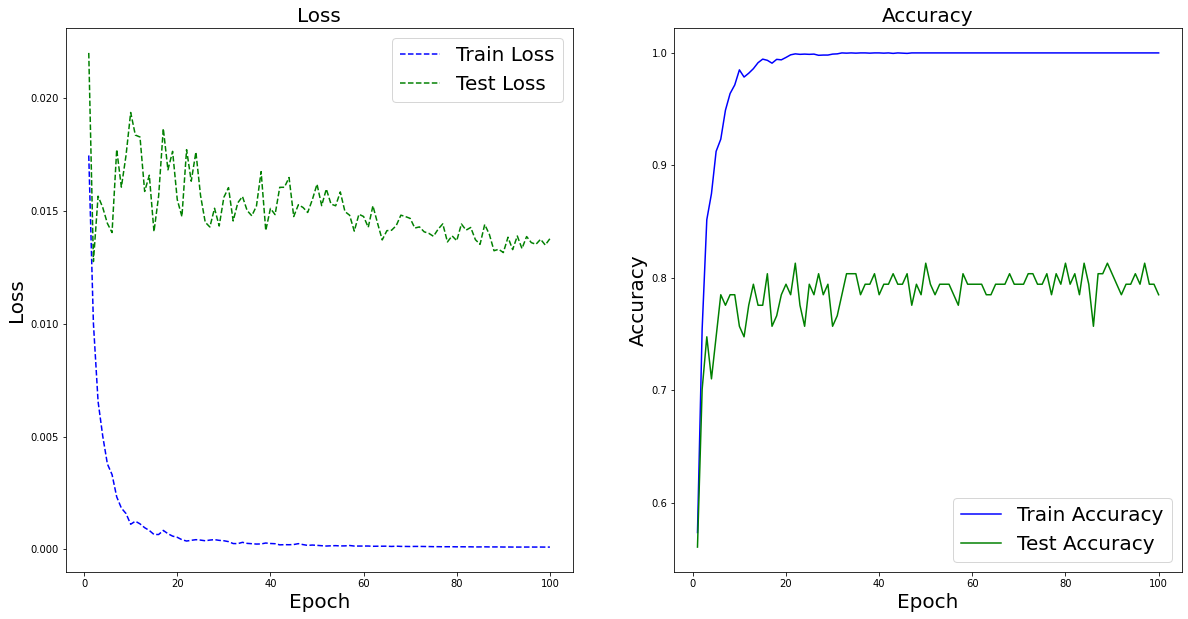

In [ ]:
visualize(train_stats, test_stats)

**Confusion matrix**

In [ ]:
current_path = os.getcwd()
result_path = join(current_path, 'results')

net = torch.load(join(result_path, 'net_best.pkl'))

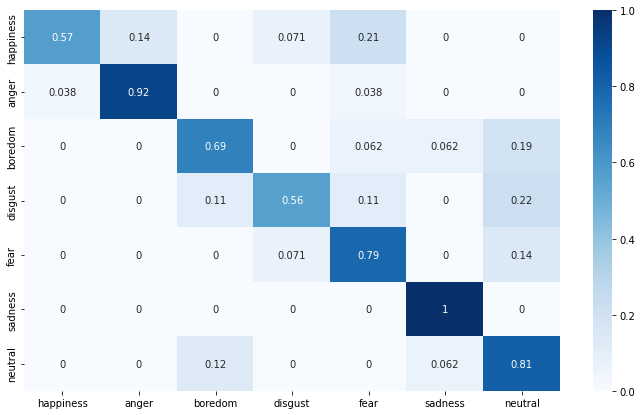

In [ ]:
y_pred = []
y_true = []
current_path = os.getcwd()

for (idx, data) in enumerate(test_loader):
        inputs = data[0].to(device, dtype=torch.float)
        label = data[1].to(device)

        with torch.no_grad():
            pred = net(inputs)
            _, predicted = pred.max(1)
            y_pred.extend(predicted.data.cpu().numpy())
            y_true.extend(label.data.cpu().numpy()) 

#classes = ['F', 'W', 'L', 'E', 'A', 'T', 'N'] 
classes = ['happiness', 'anger', 'boredom', 'disgust', 'fear', 'sadness', 'neutral'] 
c_matrix = confusion_matrix(y_true, y_pred, normalize='true')
df_cm = pd.DataFrame(c_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(join(current_path, 'confusion_matrix.png'))